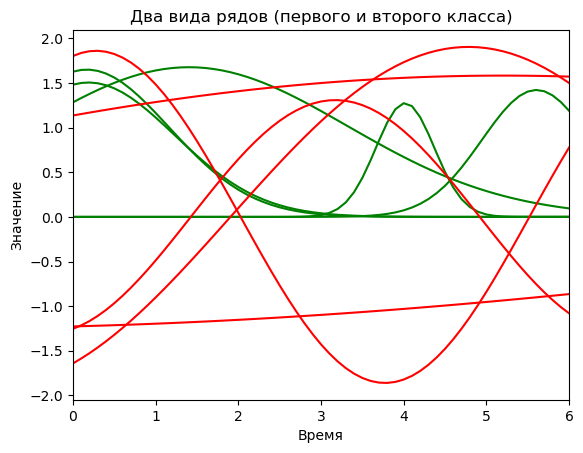

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12200 entries, 0 to 12199
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       12200 non-null  float64
 1   y       12200 non-null  float64
 2   label   12200 non-null  int64  
 3   id      12200 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 381.4 KB
3.463092339422688
1.9578497680760325
2.3392970353975984
1.9982217523020374


Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 10.51it/s]

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   y__maximum               200 non-null    float64
 1   y__minimum               200 non-null    float64
 2   y__median                200 non-null    float64
 3   y__mean                  200 non-null    float64
 4   y__count_below_mean      200 non-null    float64
 5   label__maximum           200 non-null    float64
 6   label__minimum           200 non-null    float64
 7   label__median            200 non-null    float64
 8   label__mean              200 non-null    float64
 9   label__count_below_mean  200 non-null    float64
dtypes: float64(10)
memory usage: 17.2 KB


In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, EfficientFCParameters, MinimalFCParameters

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from math import isnan

N = 100 ## количество семплов каждого класса
Nvis = 5 ## сколько семплов будем визуализировать
timePoints = 61  ## количество элементов в каждом из рядов

df = pd.DataFrame()
data = pd.DataFrame()
t = np.linspace(0, 6, timePoints) 

random.seed(42)

## генерируем семплы первого класса
for i in range(N):
    t0 = 2*np.pi*random.random()
    a1 = 5*random.random()
    A = 1 + random.random()        
    
    df['t']  = t                   ## ось времени
    df['y']  = A*np.exp(-(df.t-t0)**2/2/a1)  ## значения временного ряда
    df['label'] = 1                ## класс временного ряда 
    df['id'] = i                   ## номер временного ряда
    
    #data = data.append(df)         ## добавляем семпл в общий дейтафрейм
    data = pd.concat([data, df], ignore_index=True)
    if i < Nvis:                   ## визуализируем первые Nvis-штук
        plt.plot(df.t, df.y, color='g') 
    
## генерируем семплы второго класса    
for i in range(N, 2*N):
    A = 1 + random.random()          ## амплитуда
    w = 0 + random.random()          ## частота
    ph = 2*np.pi * random.random()   ## фаза
    
    df['t']  = t                     ## ось времени
    df['y']  = A*np.sin(t*w + ph)    ## значения временного ряда
    df['label'] = 0                  ## класс временного ряда 
    df['id'] = i                     ## номер временного ряда
    
    #data = data.append(df)           ## добавляем семпл в общий дейтафрейм
    data = pd.concat([data, df], ignore_index=True)
    if i < Nvis+N:                   ## визуализируем первые Nvis-штук
        plt.plot(df.t, df.y, color='r') 
    
## cдвигаем все значения вверх, чтобы все значения были положительными    
data['y'] = data.y + np.abs(data.y.min())
    
plt.xlabel("Время")
plt.ylabel("Значение")
plt.title('Два вида рядов (первого и второго класса)')
plt.xlim([t[0], t[-1]])
plt.show()

#print('data.shape =', data.shape)
#print('data.id.nunique() =', data.id.nunique())
#data.head(3)
data.info()

print(data[data.id == 3].y.max())
print(data[data.id == 3].y.min())
print(data[data.id == 3].y.mean())
print(data[data.id == 3].y.median())


def do_work(features):
    trainSet, testSet = train_test_split(features, test_size=0.4, random_state=42) 

    ## выводим статистику по нашим наборам
    print('trainSet.shape =', trainSet.shape)
    print('testSet.shape  =', testSet.shape)
    print()
    print('Value counts train:\n', trainSet.label.value_counts())
    print()
    print('Value counts test:\n', testSet.label.value_counts())

    ## лист фич
    featureList = trainSet.drop(['id', 'label'], axis=1).columns

    ## параметры классификатора
    params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2, 'max_features' : 1.0, 'class_weight' : 'balanced', 'random_state': 42}

    ## обучаем классификатор
    clf = RandomForestClassifier(**params).fit(trainSet[featureList], trainSet['label'])

    ## делаем предсказание на тестовом наборе
    y_pred = clf.predict(testSet[featureList])
    y_pred_proba = clf.predict_proba(testSet[featureList])[:, 1]  ## вероятности

    ## визуализируем вероятности для предсказаний
    plt.hist(y_pred_proba)
    plt.ylabel('Распределение вероятностей (test-set)')
    plt.show()
    ## создадим для удобства дейтафрейм с результатами
    res = testSet
    res['pred'] = y_pred 
    res['pred_proba'] = y_pred_proba

    ## получаем из классификатора важность фич и отображаем их
    ftmprt = pd.DataFrame()
    ftmprt['features'] = featureList
    ftmprt['importances'] = clf.feature_importances_
    ftmprt = ftmprt.sort_values('importances', ascending=False)
    print(ftmprt.head(20))
    print()
    proba = res.pred_proba

    ## считаем матрицу ошибок
    CM = confusion_matrix(res['label'], res['pred'])
    CM_DF = pd.DataFrame(data=CM, columns = ['Pos', 'Neg'])
    print(CM_DF)

    # ROC-AUC 
    FPR, TPR, thresholds = roc_curve(res['label'], res['pred_proba'])
    roc_auc = auc(FPR, TPR)
    acc = res[res['pred'] == res['label']].shape[0] / res.shape[0] ## точность
    print(f"\nAUC = {roc_auc:.3f}  Точность = {acc:.3f}\n")

    # ROC-кривая
    plt.title('Receiver Operating Characteristic')
    plt.plot(FPR, TPR, 'b', label=f'AUC = {roc_auc:.2f}')
    plt.legend(loc=
    'lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


#create dataframe
features = pd.DataFrame()
# y__maximum  y__minimum  y__median   y__mean
td = data
features['id'] = td.id
features['label'] = td.label
features['y__maximum'] = td.y.max()
features['y__minimum'] = td.y.min()
features['y__mean'] = td.y.mean()
features['y__median'] = td.y.median()

#features.info()

#false negatives here must be 2 
#do_work(features)

ext_settings = {
    'maximum' : None,
    'minimum' : None,
    'median' : None,
    'mean' : None,
    'count_below_mean': None,
}

featuresDF = extract_features(data, column_id='id', column_sort='t', default_fc_parameters=ext_settings,impute_function=impute)
featuresDF.info()